# 01Linear Model

## 1.基本形式

线性模型（linear model）试图学得一个通过属性的线性组合来进行预测的函数，即
$$f(x) = w_1 x_1 + w_2 x_2 + \dots + w_d x_d + b$$

一般向量形式：
$$f(x) = w^Tx + b$$

## 2.线性回归 Linear Regression

线性回归试图学到$f(x_i)= w x_i + b$,使得$f(x_i) \approx y_i$

则Loss为 
$$(w^*, b^*) =\operatorname*{\arg\min}_{(w, b)}\,\sum\limits\limits_{i=1}^{m}(f(x_i) - y_i)^2 $$
$$(w^*, b^*) =\operatorname*{\arg\min}_{(w, b)}\,\sum\limits_{i=1}^{m}(wx_i + b - y_i)^2 $$
利用最小二乘法求解：它通过最小化误差的平方和寻找数据的最佳函数匹配。利用最小二乘法可以简便地求得未知的数据，并使得这些求得的数据与实际数据之间误差的平方和为最小。在线性回归中，最小二乘法就是试图找到一条直线，使所有样本到直线上的欧氏距离最小

$$ \frac{\partial E_{(w,b)}}{\partial w} = 2 (w \sum\limits_{i=1}^m x_i^2 - \sum\limits_{i=1}^m(y_i - b)x_i) $$

$$ \frac{\partial E_{(w,b)}}{\partial b} = 2 (mb - \sum\limits_{i=1}^m(y_i - w x_i)) $$
令上式分别为0，可得$w$和$b$的最优解：

$$w = \frac{\sum\limits_{i=1}^m y_i(x_i - \bar x)}{\sum\limits_{i=1}^m x_2 - \frac{1}{m}(\sum\limits_{i=1}^m x_i)^2}$$
$$b = \frac{1}{m}\sum\limits_{i=1}^m (y_i - w x_i)$$
其中$\bar x = \frac{1}{m} \sum\limits_{i=1}^m x_i$
### 多元线性回归（multivariate linear regression）
同理对于数据集D，样本由d个属性描述。此时，我们试图学得
$$f(x_i) = w^T x_i + b 使得 f(x_i) \approx y_i$$
其中$\hat{w}= (w;b)$相应的把D表示为一个$m*(d+1)$大小的矩阵X
$$X = \begin{pmatrix} x_1^T & 1 \\ x_2^T & 1 \\ \vdots & \vdots \\ x_m^T & 1 \end{pmatrix} $$
同时将标记向量形式$y = (y_1;y_2;\dots ;y_m)$则有

$$\hat{w}^* = \operatorname*{\arg\min}_{\hat w}\,(y - X\hat w)^T(y - X \hat w)$$

令$E_{\hat w}=(y - X\hat w)^T(y - X\hat w)$,对\hat w求导得：

$$ \frac{\partial E_{\hat w}}{\partial \hat w} = 2 X^T(X\hat w - y)$$

当$XX^T$为满秩矩阵或正定矩阵时，令上式为0可得$w_* = (X^TX)^{-1}X^Ty$,则多元线性回归模型为

$$f(x_i) = \hat x_i^{T}(X^T X)^{-1}X^T y$$

但是实际中$X^T X$往往不是满秩矩阵，例如在变量数会多于样例数，导致X的行数多于列数。此时可解出多个$\hat w$,选择哪一个，
则由模型偏好选出，常见做法是使用正则化。

## linear regression 手动实现

In [1]:
# import packages and modules
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)

1.2.0


### 生成数据集
$$price = w_{area}area + w_{age}age + b$$

In [2]:
# set input feature number
num_inputs = 2
# set example number
num_examples = 1000

# set true weight and bias in order to generate corresponded label
true_w = [2, -3.4]
true_b = 4.2

features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)

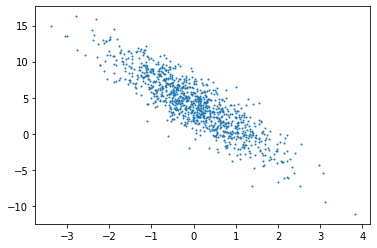

In [3]:
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

### 读取数据集

In [4]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)

In [5]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.4323,  0.4476],
        [ 0.7059,  0.9744],
        [ 1.5117,  0.9684],
        [-0.9582, -1.3797],
        [-0.6680,  1.6117],
        [ 0.8260, -0.1680],
        [-0.6586, -0.7727],
        [-0.3681,  0.3230],
        [ 1.2673, -0.6125],
        [ 0.7261, -0.3756]]) 
 tensor([-0.2016,  2.2850,  3.9416,  6.9666, -2.6326,  6.4188,  5.5109,  2.3762,
         8.8051,  6.9348])


### 初始化模型参数

In [6]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

### 定义模型
定义用来训练参数的训练模型：
$$price = w_{area}area + w_{age}age + b$$

In [7]:
def linear_regression(X, w, b):
    return torch.mm(X, w) + b

### 定义损失函数(MSE均方误差)
$$l^{(i)}(w,b)=\frac{1}{2}(\hat y^{(i)} - y^{(i)})^2$$

In [8]:
def MSE_loss(y_pred, y):
    return pow((y_pred - y.view(y_pred.size())), 2) / 2

### 定义优化函数
minbatchGD：
$$(w, b) \gets (w,b) - \frac{\eta}{|\beta|}\sum_{i \epsilon \beta} \partial (w,b)l^{(i)}(w,b) $$

In [9]:
def minbatchGD(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

### 训练

In [10]:
lr = 0.03
num_epochs = 5

net = linear_regression
loss = MSE_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()
        l.backward()
        minbatchGD([w, b], lr, batch_size)
        # reset parameter gradient
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.043652
epoch 2, loss 0.000175
epoch 3, loss 0.000054
epoch 4, loss 0.000054
epoch 5, loss 0.000054


In [11]:
w, true_w, b, true_b

(tensor([[ 2.0001],
         [-3.3996]], requires_grad=True),
 [2, -3.4],
 tensor([4.1994], requires_grad=True),
 4.2)